## Set-up environment

Installation of the libraries which we'll use: HuggingFace Transformers and Datasets.

In [ ]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.3 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tqdm import trange

import pandas as pd
import numpy as np

In [ ]:
import pandas as pd

root = "https://raw.githubusercontent.com/alfcan/CADOCS_NLU_Model/main/dataset.csv"

df = pd.read_csv(root, sep = ';', names = ["request", "intent"])
label_mapping = {'get_smells': 0, 'get_smells_date': 1, 'report': 2, 'info': 3}
df['intent'] = df['intent'].map(label_mapping)

In [ ]:
request = df.request.values
intent = df.intent.values

We divide the dataset into train and test sets (70\30).

The test set is further divided into a test set and a validation set.

In [ ]:
test_ratio = 0.3

val_ratio = 0.33

# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16


# Indices of the train set and temp set(validation + test sets) splits stratified by labels
train_request, temp_request, train_intent, temp_intent = train_test_split(
    request,
    intent,
    test_size = test_ratio,
    shuffle = True,
    stratify = intent)

# We divide then temp_idx in test_idx (test set) and val_idx ( validation set)
test_request, val_request, test_intent, val_intent = train_test_split(
    temp_request,
    temp_intent,
    test_size = val_ratio,
    shuffle = True,
    stratify = temp_intent)

<Axes: >

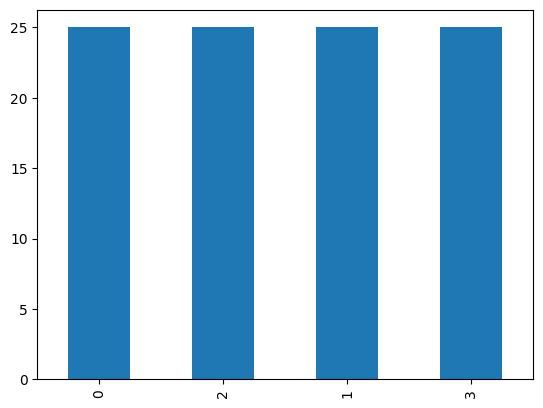

In [ ]:
import matplotlib.pyplot as plt

# Converti l'array NumPy in un oggetto Pandas Series
train_intent_series = pd.Series(train_intent)

# Crea un grafico a barre per il conteggio delle occorrenze di ogni valore unico
train_intent_series.value_counts().plot(kind='bar')

In [ ]:
'''
# Tokenizer of BERT
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
)
'''
tokenizer = RobertaTokenizer.from_pretrained(
    'roberta-base',
    do_lower_case = True
)

In [ ]:
'''Tokenize each set splitted''' 


def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

def preprocessing_batch(data_set):
    token_id = []
    attention_masks = []
    for sample in data_set:
      encoding_dict = preprocessing(sample, tokenizer)
      token_id.append(encoding_dict['input_ids']) 
      attention_masks.append(encoding_dict['attention_mask'])
    token_id = torch.cat(token_id, dim = 0)
    attention_masks = torch.cat(attention_masks, dim = 0)
    return token_id,attention_masks

train_token_id,train_attention_masks = preprocessing_batch(train_request)
test_token_id,test_attention_masks = preprocessing_batch(test_request)
val_token_id,val_attention_masks = preprocessing_batch(val_request)

train_intent = torch.tensor(train_intent)
test_intent = torch.tensor(test_intent)
val_intent = torch.tensor(val_intent)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


DataLoader -> batch data during training and validation of deep learning models.

In [ ]:

# Batch size: 16, 32
batch_size = 32

# Train and validation sets
train_set = TensorDataset(train_token_id, 
                          train_attention_masks, 
                          train_intent)

val_set = TensorDataset(val_token_id, 
                        val_attention_masks, 
                        val_intent)

test_set = TensorDataset(test_token_id, 
                        test_attention_masks, 
                        test_intent)

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


test_dataloader = DataLoader(
            test_set,
            sampler = SequentialSampler(test_set),
            batch_size = batch_size
        )

In [ ]:
'''
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False,
)
'''

model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False,
)

# Learning rates (Adam): 5e-5, 3e-5, 2e-5.
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 3e-5,
                              eps = 1e-10
                              )

model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
# preds -> model predictions
# labels -> sample label
# class_label -> class for which you want to calculate TP, FP, TN, FN
def b_tp(preds, labels, class_label):
  return sum([pred == label and pred == class_label for pred, label in zip(preds, labels)])

def b_fp(preds, labels, class_label):
  return sum([pred != label and pred == class_label for pred, label in zip(preds, labels)])

def b_tn(preds, labels, class_label):
  return sum([pred == label and label != class_label for pred, label in zip(preds, labels)])

def b_fn(preds, labels, class_label):
  return sum([pred != label and label != class_label for pred, label in zip(preds, labels)])


'''
Returns the following metrics:
  - accuracy
  - precision
  - recall
  - specificity
'''
def b_metrics(preds, labels):
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels, 0) + b_tp(preds, labels, 1) + b_tp(preds, labels, 2) + b_tp(preds, labels, 3)
  tn = b_tn(preds, labels, 0) + b_tn(preds, labels, 1) + b_tn(preds, labels, 2) + b_tn(preds, labels, 3)
  fp = b_fp(preds, labels, 0) + b_fp(preds, labels, 1) + b_fp(preds, labels, 2) + b_fp(preds, labels, 3)
  fn = b_fn(preds, labels, 0) + b_fn(preds, labels, 1) + b_fn(preds, labels, 2) + b_fn(preds, labels, 3)
  b_accuracy = (tp + tn) / (tp + tn + fp + fn)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of epochs: 2, 3, 4
epochs = 8

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        #reset gradient value for the new epoch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)
        

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

# save the trained model to a file
PATH = './bert.pth'
torch.save(model, PATH)

Epoch:  12%|█▎        | 1/8 [00:01<00:11,  1.70s/it]


	 - Train loss: 1.4036
	 - Validation Accuracy: 0.4000
	 - Validation Precision: 0.4000
	 - Validation Recall: 0.1818
	 - Validation Specificity: 0.6667



Epoch:  25%|██▌       | 2/8 [00:02<00:06,  1.11s/it]


	 - Train loss: 1.3658
	 - Validation Accuracy: 0.4000
	 - Validation Precision: 0.4000
	 - Validation Recall: 0.1818
	 - Validation Specificity: 0.6667



Epoch:  38%|███▊      | 3/8 [00:03<00:04,  1.07it/s]


	 - Train loss: 1.2187
	 - Validation Accuracy: 0.8000
	 - Validation Precision: 0.8000
	 - Validation Recall: 0.5714
	 - Validation Specificity: 0.9231



Epoch:  50%|█████     | 4/8 [00:03<00:03,  1.20it/s]


	 - Train loss: 0.8949
	 - Validation Accuracy: 1.0000
	 - Validation Precision: 1.0000
	 - Validation Recall: 1.0000
	 - Validation Specificity: 1.0000



Epoch:  62%|██████▎   | 5/8 [00:04<00:02,  1.27it/s]


	 - Train loss: 0.5498
	 - Validation Accuracy: 1.0000
	 - Validation Precision: 1.0000
	 - Validation Recall: 1.0000
	 - Validation Specificity: 1.0000



Epoch:  75%|███████▌  | 6/8 [00:05<00:01,  1.36it/s]


	 - Train loss: 0.3447
	 - Validation Accuracy: 1.0000
	 - Validation Precision: 1.0000
	 - Validation Recall: 1.0000
	 - Validation Specificity: 1.0000



Epoch:  88%|████████▊ | 7/8 [00:05<00:00,  1.38it/s]


	 - Train loss: 0.1941
	 - Validation Accuracy: 1.0000
	 - Validation Precision: 1.0000
	 - Validation Recall: 1.0000
	 - Validation Specificity: 1.0000



Epoch: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


	 - Train loss: 0.1015
	 - Validation Accuracy: 1.0000
	 - Validation Precision: 1.0000
	 - Validation Recall: 1.0000
	 - Validation Specificity: 1.0000



In [ ]:
# load the model saved
PATH = './bert.pth'
model = torch.load(PATH)

# Tracking variables 
test_accuracy = []
test_precision = []
test_recall = []
test_specificity = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    eval_output = model(b_input_ids, 
                        token_type_ids = None, 
                        attention_mask = b_input_mask)
    logits = eval_output.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    # Calculate validation metrics
    b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
    test_accuracy.append(b_accuracy)
    # Update precision only when (tp + fp) !=0; ignore nan
    if b_precision != 'nan': test_precision.append(b_precision)
    # Update recall only when (tp + fn) !=0; ignore nan
    if b_recall != 'nan': test_recall.append(b_recall)
    # Update specificity only when (tn + fp) !=0; ignore nan
    if b_specificity != 'nan': test_specificity.append(b_specificity)

print('\t - Test Accuracy: {:.4f}'.format(sum(test_accuracy)/len(test_accuracy)))
print('\t - Test Precision: {:.4f}'.format(sum(test_precision)/len(test_precision)) if len(test_precision)>0 else '\t - Test Precision: NaN')
print('\t - Test Recall: {:.4f}'.format(sum(test_recall)/len(test_recall)) if len(test_recall)>0 else '\t - Test Recall: NaN')
print('\t - Test Specificity: {:.4f}\n'.format(sum(test_specificity)/len(test_specificity)) if len(test_specificity)>0 else '\t - Test Specificity: NaN')

	 - Test Accuracy: 0.9310
	 - Test Precision: 0.9310
	 - Test Recall: 0.8182
	 - Test Specificity: 0.9759



In [ ]:
#input testing
requests_smells = [
                    "Hello CADOCS, which community smells have this project LINK?", 
                    "Hi CADOCS, give me the community smells on this project LINK", 
                    "CADOCS, community smells on the project LINK?",
                    "Give me code smells on LINK"
                  ]

requests_smells_date = [
                        "Hello CADOCS, which community smells have this project LINK after 18/05/2022?", 
                        "Hi CADOCS, give me the community smells after DATE on this project LINK", 
                        "CADOCS, community smells starting from 10/06/2022 on the project LINK?",
                        "Give me code smells on LINK after 06/02/2020"
                       ]

requests_report = [ 
                    "Hello CADOCS, can you give me the report of the last execution?", 
                    "CADOCS, give me the report of the last execution", 
                    "Hi CADOCS, give me the last execution",
                    "Give me the report of the last execution"
                  ]     

requests_info =   [ 
                    "CADOCS what are community smells?",
                    "What can you do?",
                    "Which types of community smells can you return?",
                    "Hi CADOCS, what can you do?",
                    "Talk me about community smells"
                  ]                                      

requests_arrays = [requests_smells, requests_smells_date, requests_report, requests_info]
array_names = ['requests_smells', 'requests_smells_date', 'requests_report', 'requests_info']

for requests, array_name in zip(requests_arrays, array_names):
  print("Array:", array_name)

  for request in requests:
    request_ids = tokenizer.encode_plus(
                            request,
                            add_special_tokens = True,
                            max_length = 32,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt'
                      )

    input_ids = torch.tensor(request_ids['input_ids']).to(model.device)

    with torch.no_grad():
        output = model(input_ids)

    predictions = output.logits.argmax(dim=1)
    predicted_class = predictions.item()

    for label, index in label_mapping.items():
        if index == predicted_class:
            predicted_label = label
            break

    print("Predicted class: " + predicted_label)

Array: requests_smells
Predicted class: get_smells
Predicted class: get_smells


<ipython-input-14-f0a9035fdb5b>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(request_ids['input_ids']).to(model.device)


Predicted class: get_smells
Predicted class: get_smells
Array: requests_smells_date
Predicted class: get_smells_date
Predicted class: get_smells
Predicted class: get_smells_date
Predicted class: get_smells_date
Array: requests_report
Predicted class: report
Predicted class: report
Predicted class: report
Predicted class: report
Array: requests_info
Predicted class: get_smells
Predicted class: get_smells
Predicted class: get_smells
Predicted class: get_smells
Predicted class: get_smells
